# Introduction

We aim to predict the sequence evolution of SARS-CoV-2 spike protein by using deep learning. The methods and codes here are modified from a flu-forecaster developed by Eric Ma. 
reference: https://github.com/ericmjl/flu-sequence-predictor

## Data

The data come from the [NCBI virus database ](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=taxid:2697049&CollectionDate_dr=1950-01-01T00:00:00Z%20TO%20NOW&CreateDate_dt=1950-01-01T00:00:00Z%20TO%20NOW)(IRD). Search parameters were as follows:

- Species: Severe acute respiratory syndrome coronavirus 2
- Sequence Length: 1273
- Nucleotide completeness: complete
- Protein: Surface glycoprotein
- Colletion date: 2020/5/1~2021/12/31
- Graphic regions: North America
- isolation source: oronasopharynx
- Host: Homo (humans)

## Learning Strategy

1. Use variational autoencoders, a deep learning method, to learn a latent manifold on which sequence evolution is taking place. 
1. Simultaneously construct a genotype network of SARS-CoV-2 evolution.
    1. Nodes: SARS-CoV-2 protein sequences.
    1. Edges: Sequences differ by one amino acid.
1. Sanity checks:
    1. Plot edit distance between any two random pairs of protein sequences against their manifold distance. There should be a linear relationship between the two.
1. Validation:
    1. MVP validation will be done by doing one round of "back testing" - we hold out data from 2021/8/1 to 2021/12/31, and predict whether data shows up or not.
    
    
## Technical aspects demonstrated

1. Deep learning.
1. Basic time series analysis.
1. Genomics.

In [1]:
!pip install Levenshtein
!pip install gpflow
!pip install Bio
!pip install utils
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 14.4 MB/s 
     |████████████████████████████████| 2.2 MB 77.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 446 kB 13.5 MB/s 
     |████████████████████████████████| 107 kB 66.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 273 kB 15.5 MB/s 
     |████████████████████████████████| 2.7 MB 62.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 13.3 MB/s 
     |████████████████████████████████| 1.8 MB 59.3 MB/s 
  Created wheel for theano-pymc: filename

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
path = '/content/drive/MyDrive/SARS-CoV-2-sequence-predictor'
os.chdir(path)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import tensorflow as tf
import pymc3 as pm
import gpflow

plt.style.use('fivethirtyeight')

from Bio import SeqIO
from copy import deepcopy
from datetime import datetime
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model, model_from_json
from keras import backend as K
from keras import losses
from keras.callbacks import EarlyStopping
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from random import sample

from Levenshtein import distance as levD
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from pymc3 import gp
from sklearn.model_selection import train_test_split
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean as eucD

from custom import encode_array, save_model, get_density_interval
from utils.data import load_sequence_and_metadata

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.8/dist-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/usr/local/lib/python3.8/dist-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


We first will start with doing some basic cleaning of the data.

1. We want to forecast sequences from Aug 2021-Dec 2021. Therefore, any machine learning fitting can only be done on the data up to Jul 2021; any predictions are to be done on sequences Aug 2021-Dec 2021.

In [5]:
# Let's start by loading the protein sequence FASTA file and metadata.
def load_sequence_and_metadata(seq_nums):
    """
    Returns the sequences as a list of SeqRecords, and metadata as a pandas
    DataFrame.
    """
    sequences = [s for s in SeqIO.parse(f"data_covid19/sequences_{seq_nums}.fasta", "fasta")]
    metadata = pd.read_csv(f"data_covid19/sequences_{seq_nums}.csv", parse_dates=["Collection_Date"])
    return sequences, metadata
    
sequences, metadata = load_sequence_and_metadata('2020May_to_2021Dec')
assert len(sequences) == len(metadata)
print(len(sequences), len(metadata))

21742 21742


In [7]:
# split into training and test set.
from datetime import datetime

datetime_cutoff = datetime(2021, 8, 1) # set the cut-off
# sefine the training set
training_metadata = metadata[metadata['Collection_Date'] < datetime_cutoff]
training_metadata_accession = training_metadata['Accession'].values
training_idxs = [i for i, s in enumerate(sequences) if s.id in training_metadata_accession]
# define the testing set
test_metadata = metadata[metadata['Collection_Date'] >= datetime_cutoff]
testing_metadata_accession = test_metadata['Accession'].values
test_idxs = [i for i, s in enumerate(sequences) if s.id in testing_metadata_accession]

# Encode as array by one-hot-encoding of sequences
from custom import encode_array, get_density_interval
sequence_array = encode_array(sequences)

training_array = sequence_array[training_idxs]
test_array = sequence_array[test_idxs]

training_sequences = [sequences[i] for i in training_idxs]
test_sequences = [sequences[i] for i in test_idxs]

24


To visualize what's going on, let's display the data below.

In [8]:
metadata

,Accession,Species,Length,Sequence_Type,Protein,Host,Isolation_Source,Collection_Date
0,UHK31336.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2020-01-01
1,UHK31348.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2020-01-01
2,UHK32125.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2020-01-01
3,UHK32640.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2020-01-01
4,UHK33464.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2020-01-01
...,...,...,...,...,...,...,...,...
21737,UHR01755.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2021-12-18
21738,UHR01481.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2021-12-19
21739,UHR01505.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2021-12-19
21740,UHR01648.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2021-12-19


In [9]:
test_array.shape   # the one-of-K encoding of sequences.

(1062, 30552)

In [10]:
training_array.shape  # also a one-of-K encoding of sequences

(20680, 30552)

Some sanity checks implemented below:

1. Length of training (or testing) array is the same as the metadata.

In [11]:
# Sanity checks
assert len(training_array) == len(training_metadata)
assert len(test_array) == len(test_metadata)

# Diagnostic prints that may be helpful later
print(training_array.shape[1])

30552


Let's now build the variational autoencoder model. This is a deep learning model that provides us with a way to learn a latent representation of discrete sequence space as a continuous representation instead. It's both a visualization tool and a deep learning data compression tool.

In [12]:
# Set up VAE.
with tf.device('/gpu:0'):
    intermediate_dim = 1000
    encoding_dim = 3
    latent_dim = encoding_dim
    epsilon_std = 1.0
    nb_epoch = 250

    x = Input(shape=(training_array.shape[1],))
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(latent_dim, ), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    x_decoded_mean = Dense(training_array.shape[1], activation='sigmoid')(z_mean)
    vae = Model(x, x_decoded_mean)
    vae.compile(optimizer='adam', loss='binary_crossentropy')
    
    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)
    encoder_var = Model(x, z_log_var)
    x_train, x_test = train_test_split(training_array)
    early_stopping = EarlyStopping(monitor="val_loss", patience=2)

    # build the decoder
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = vae.layers[-1]
    # create the decoder model
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

    vae.summary()

    # Train the VAE to learn weights
    vae.fit(x_train, x_train,
            shuffle=True,
            epochs=nb_epoch,
            validation_data=(x_test, x_test),
            callbacks=[early_stopping]
            )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30552)]           0         
                                                                 
 dense (Dense)               (None, 3)                 91659     
                                                                 
 dense_2 (Dense)             (None, 30552)             122208    
                                                                 
Total params: 213,867
Trainable params: 213,867
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
485/485 [==============================] - 16s 31ms/step - loss: 0.0275 - val_loss: 0.0011
Epoch 2/250
485/485 [==============================] - 12s 26ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 3/250
485/485 [==============================] - 12s 26ms/step - loss: 9.6468e-04 - val_loss: 9.7907e-04
Ep

# Putting VAEs into Production

How might we put the VAE into production? Keras allows us to save and load models as `.h5` and `.json` files. (Reference [here](http://machinelearningmastery.com/save-load-keras-deep-learning-models/).)

I will save the model as it is right now under the `trained_models/` directory.

In [13]:
def save_model(model, path):
    with open(path + '.json', 'w+') as f:
        model_json = model.to_json()
        f.write(model_json)

    model.save_weights(path + '.h5')


def load_models(path):
    with open(path + '.json', 'r+') as f:
        json_rep = ''
        for l in f.readlines():
            json_rep += l

    model = model_from_json(json_rep)
    model.load_weights(path + '.h5')

    return model

In [16]:
save_model(vae, 'trained_models/vae')
save_model(encoder, 'trained_models/encoder')
save_model(decoder, 'trained_models/decoder')

In [17]:
vae = load_models('trained_models/vae')
encoder = load_models('trained_models/encoder')
decoder = load_models('trained_models/decoder')

In [18]:
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30552)]           0         
                                                                 
 dense (Dense)               (None, 3)                 91659     
                                                                 
 dense_2 (Dense)             (None, 30552)             122208    
                                                                 
Total params: 213,867
Trainable params: 213,867
Non-trainable params: 0
_________________________________________________________________


In [19]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30552)]           0         
                                                                 
 dense (Dense)               (None, 3)                 91659     
                                                                 
Total params: 91,659
Trainable params: 91,659
Non-trainable params: 0
_________________________________________________________________


In [20]:
decoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 30552)             122208    
                                                                 
Total params: 122,208
Trainable params: 122,208
Non-trainable params: 0
_________________________________________________________________


In [23]:
training_embeddings_mean = encoder.predict(training_array)
training_embeddings_mean.shape

647/647 [==============================] - 1s 2ms/step


(20680, 3)

Let's compute the convex hull of the `test_embedding` points, so that it can be laid over the `training_embedding` points.

In [24]:
test_embeddings_mean = encoder.predict(test_array)
test_embeddings_hull = ConvexHull(test_embeddings_mean)

34/34 [==============================] - 0s 2ms/step


Before moving on, save test embeddings and training embeddings to disk

In [25]:
pd.DataFrame(test_embeddings_mean)

,0,1,2
0,-33.915768,39.286411,-66.146690
1,-33.915768,39.286411,-66.146690
2,-33.915768,39.286411,-66.146690
3,-30.678169,42.131645,-66.724968
4,-33.915768,39.286411,-66.146690
...,...,...,...
1057,-45.042526,45.974907,-49.200756
1058,-44.999054,45.946602,-49.152485
1059,-44.597897,45.837612,-49.229973
1060,-44.590324,45.442577,-48.737282


In [26]:
lowp, highp = get_density_interval(99, training_embeddings_mean, axis=0)
lowp, highp

(array([-64.88259888,  39.22835964, -67.10661316]),
 array([-17.85536003,  77.47402206, -25.85883713]))

Let's visualize the latent space, which is currently encoded in 3 dimensions.

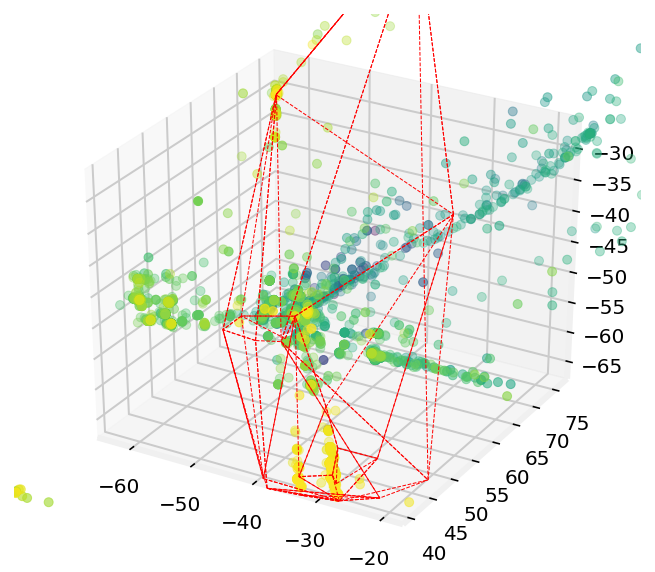

In [27]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(training_embeddings_mean[:, 0], 
           training_embeddings_mean[:, 1], 
           training_embeddings_mean[:, 2], 
           c=training_metadata['Collection_Date'], cmap='viridis')
# Plot the convex hull of the sequences of testing dataset.
for simplex in test_embeddings_hull.simplices:
    ax.plot(test_embeddings_mean[simplex, 0], 
            test_embeddings_mean[simplex, 1], 
            test_embeddings_mean[simplex, 2], 'r--', lw=0.5)
ax.set_xlim(lowp[0], highp[0])
ax.set_ylim(lowp[1], highp[1])
ax.set_zlim(lowp[2], highp[2])
ax.set_facecolor('white')
plt.show()

Let's save the learned coordinates to disk, so that it can be visualized in a separate file. Uncomment the cell if new training happened, and the coordinates need to be updated.

In [28]:
training_metadata.loc[:, 'coords0'] = training_embeddings_mean[:, 0]
training_metadata.loc[:, 'coords1'] = training_embeddings_mean[:, 1]
training_metadata.loc[:, 'coords2'] = training_embeddings_mean[:, 2]
training_metadata.tail()
# training_metadata.to_csv('data/metadata_with_embeddings.csv')

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Accession,Species,Length,Sequence_Type,Protein,Host,Isolation_Source,Collection_Date,coords0,coords1,coords2
20675,QYK99653.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2021-07-31,-28.504021,39.865234,-65.954712
20676,QYK99689.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2021-07-31,-30.602047,42.200142,-65.296387
20677,QYK99713.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2021-07-31,-28.504021,39.865234,-65.954712
20678,QYK99725.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2021-07-31,-31.741619,37.020000,-65.376427
20679,QYK99737.1,Severe acute respiratory syndrome-related coro...,1273,GenBank,surface glycoprotein,Homo sapiens,oronasopharynx,2021-07-31,-28.504021,39.865234,-65.954712


# Sanity Check 1: Distances

I want to do a sanity check on the protein sequences. The goal here is to figure out whether short embedding euclidean distances roughly equals to short Levenshtein distances between sequences. I will sample 1000 pairs of sequences, compute their Levenshtein distance and their euclidean distances, and check that there is a linear relationship between the two.

In [29]:
# Generate pairs of random indices.
indices = np.random.randint(low=0, high=len(training_array), size=(1000, 2))
indices

array([[ 2999, 11855],
       [13500, 14632],
       [18036, 13366],
       ...,
       [16447, 13048],
       [ 3391, 15783],
       [19357,  5457]])

Text(0, 0.5, 'Euclidean Distance')

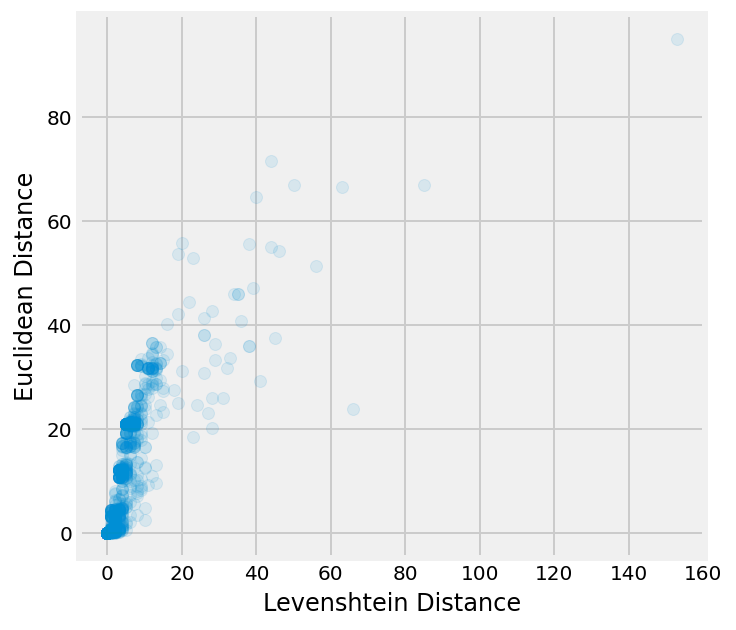

In [30]:
lev_dists = []
euc_dists = []
for i1, i2 in indices:
    lev_dist = levD(str(training_sequences[i1].seq), str(training_sequences[i2].seq))
    euc_dist = eucD(training_embeddings_mean[i1], training_embeddings_mean[i2])
    
    lev_dists.append(lev_dist)
    euc_dists.append(euc_dist)
    
fig = plt.figure(figsize=(5,5))
plt.scatter(lev_dists, euc_dists, alpha=0.1)
plt.xlabel('Levenshtein Distance')
plt.ylabel('Euclidean Distance')

In [31]:
pd.Series(lev_dists).corr(pd.Series(euc_dists))

0.7553832192275277

## Visualize Evolutionary Trajectory over Time

I'm now going to try visualizing the evolutionary trajectory of the surface glycoprotein, day-by-day, week-by-week or quarter-by-quarter. We will take the average coordinate per day (week or quarter), and plot them in 3D space.

In [32]:
from ipywidgets import interact
from ipywidgets.widgets import Dropdown

tm_coords = deepcopy(training_metadata)  # tm_coords means "training metadata with coordinates"
tm_coords['coord0'] = training_embeddings_mean[:, 0]
tm_coords['coord1'] = training_embeddings_mean[:, 1]
tm_coords['coord2'] = training_embeddings_mean[:, 2]
avg_coords_by_day = tm_coords.groupby('Collection_Date')\
                            [['coord0', 'coord1', 'coord2']].median().\
                            resample("D").median().dropna().reset_index()

avg_coords_by_quarter = tm_coords.groupby('Collection_Date')\
                            [['coord0', 'coord1', 'coord2']].median().\
                            resample("Q").median().dropna().reset_index()

        
avg_coords_by_week = tm_coords.groupby('Collection_Date')\
                            [['coord0', 'coord1', 'coord2']].median().\
                            resample("W").median().dropna().reset_index()

@interact(elev=(-180, 180, 10), azim=(0, 360, 10))
def plot_daily_avg(elev, azim):

    fig = plt.figure(figsize=(24,8))
    ax1 = fig.add_subplot(1,3,1, projection='3d')
    ax1.scatter(xs=avg_coords_by_day['coord0'],
                ys=avg_coords_by_day['coord1'],
                zs=avg_coords_by_day['coord2'],
                c=avg_coords_by_day['Collection_Date'], 
                cmap='viridis')
    ax1.view_init(elev, azim)
    ax1.set_title('by day')
    
    ax2 = fig.add_subplot(1,3,3, projection='3d')
    ax2.scatter(xs=avg_coords_by_quarter['coord0'], 
                ys=avg_coords_by_quarter['coord1'], 
                zs=avg_coords_by_quarter['coord2'], 
                c=avg_coords_by_quarter['Collection_Date'], 
                cmap='viridis')
    ax2.view_init(elev=elev, azim=azim)
    ax2.set_title('by quarter')

    ax3 = fig.add_subplot(1,3,2, projection='3d')
    ax3.scatter(xs=avg_coords_by_week['coord0'], 
                ys=avg_coords_by_week['coord1'], 
                zs=avg_coords_by_week['coord2'], 
                c=avg_coords_by_week['Collection_Date'], 
                cmap='viridis')
    ax3.view_init(elev=elev, azim=azim)
    ax3.set_title('by week')

    ax1.set_xlim(ax1.get_xlim())
    ax1.set_ylim(ax1.get_ylim())
    ax1.set_zlim(ax1.get_zlim())
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_zlim(ax1.get_zlim())
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_ylim(ax1.get_ylim())
    ax3.set_zlim(ax1.get_zlim())
    
    for simplex in test_embeddings_hull.simplices:
        ax1.plot(test_embeddings_mean[simplex, 0], 
                 test_embeddings_mean[simplex, 1], 
                 test_embeddings_mean[simplex, 2], 
                 'k--', lw=0.2)
    for simplex in test_embeddings_hull.simplices:
        ax2.plot(test_embeddings_mean[simplex, 0], 
                 test_embeddings_mean[simplex, 1], 
                 test_embeddings_mean[simplex, 2], 
                 'k--', lw=0.2)
    for simplex in test_embeddings_hull.simplices:
        ax3.plot(test_embeddings_mean[simplex, 0], 
                 test_embeddings_mean[simplex, 1], 
                 test_embeddings_mean[simplex, 2], 
                 'k--', lw=0.2)
        
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')
    ax3.set_facecolor('white')

    plt.show()


interactive(children=(IntSlider(value=0, description='elev', max=180, min=-180, step=10), IntSlider(value=180,…

Let's transform the 3D plots into three 1D plots. (This is just a viz aid.)

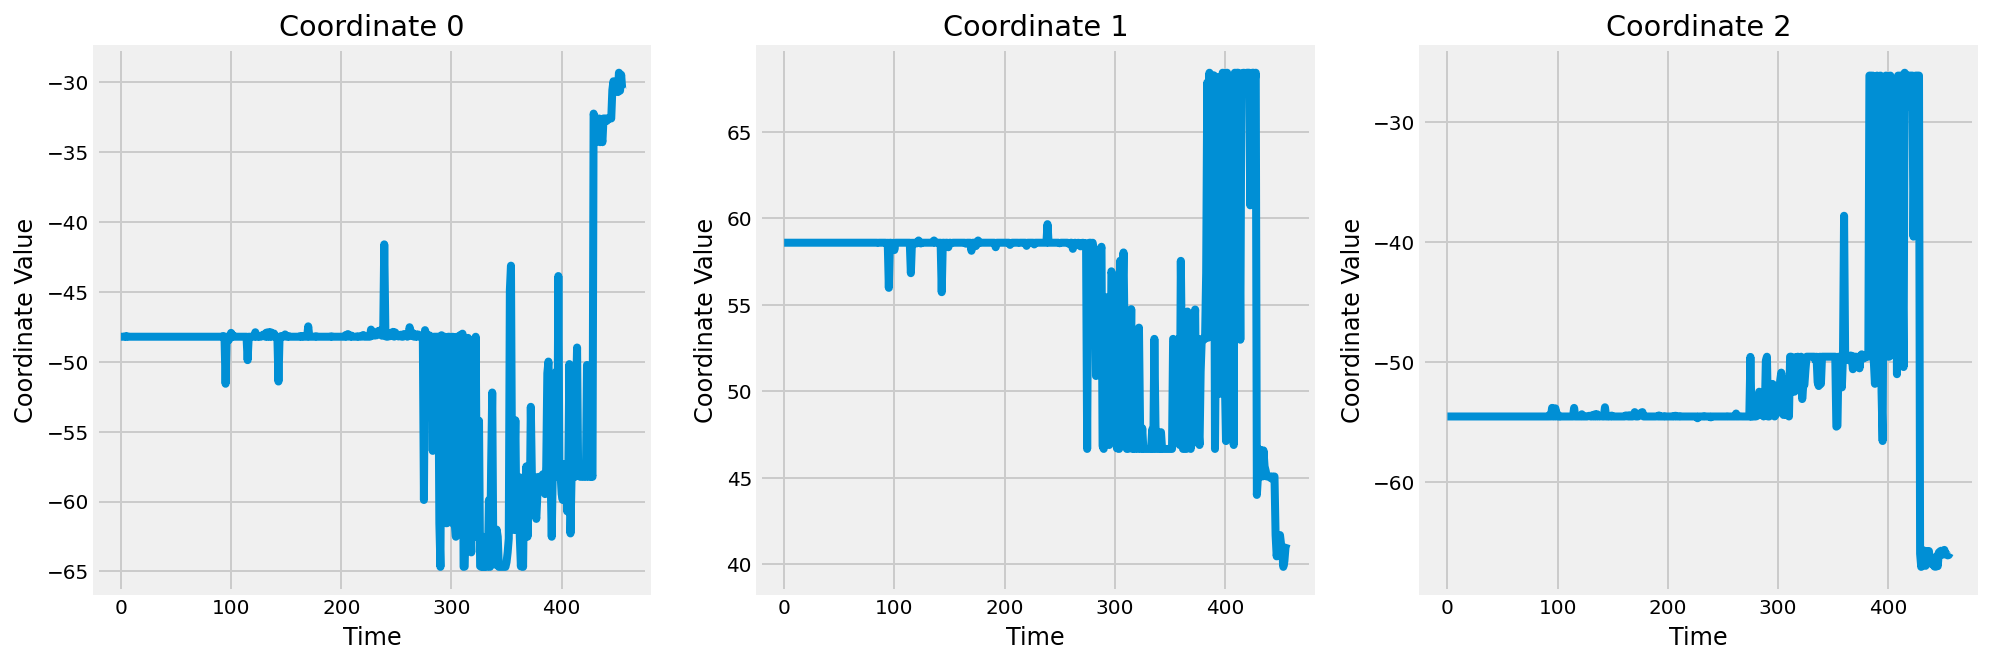

In [33]:
# by day
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(avg_coords_by_day['coord0'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Coordinate Value')
ax1.set_title('Coordinate 0')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(avg_coords_by_day['coord1'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Coordinate Value')
ax2.set_title('Coordinate 1')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(avg_coords_by_day['coord2'])
ax3.set_xlabel('Time')
ax3.set_ylabel('Coordinate Value')
ax3.set_title('Coordinate 2')
plt.show()

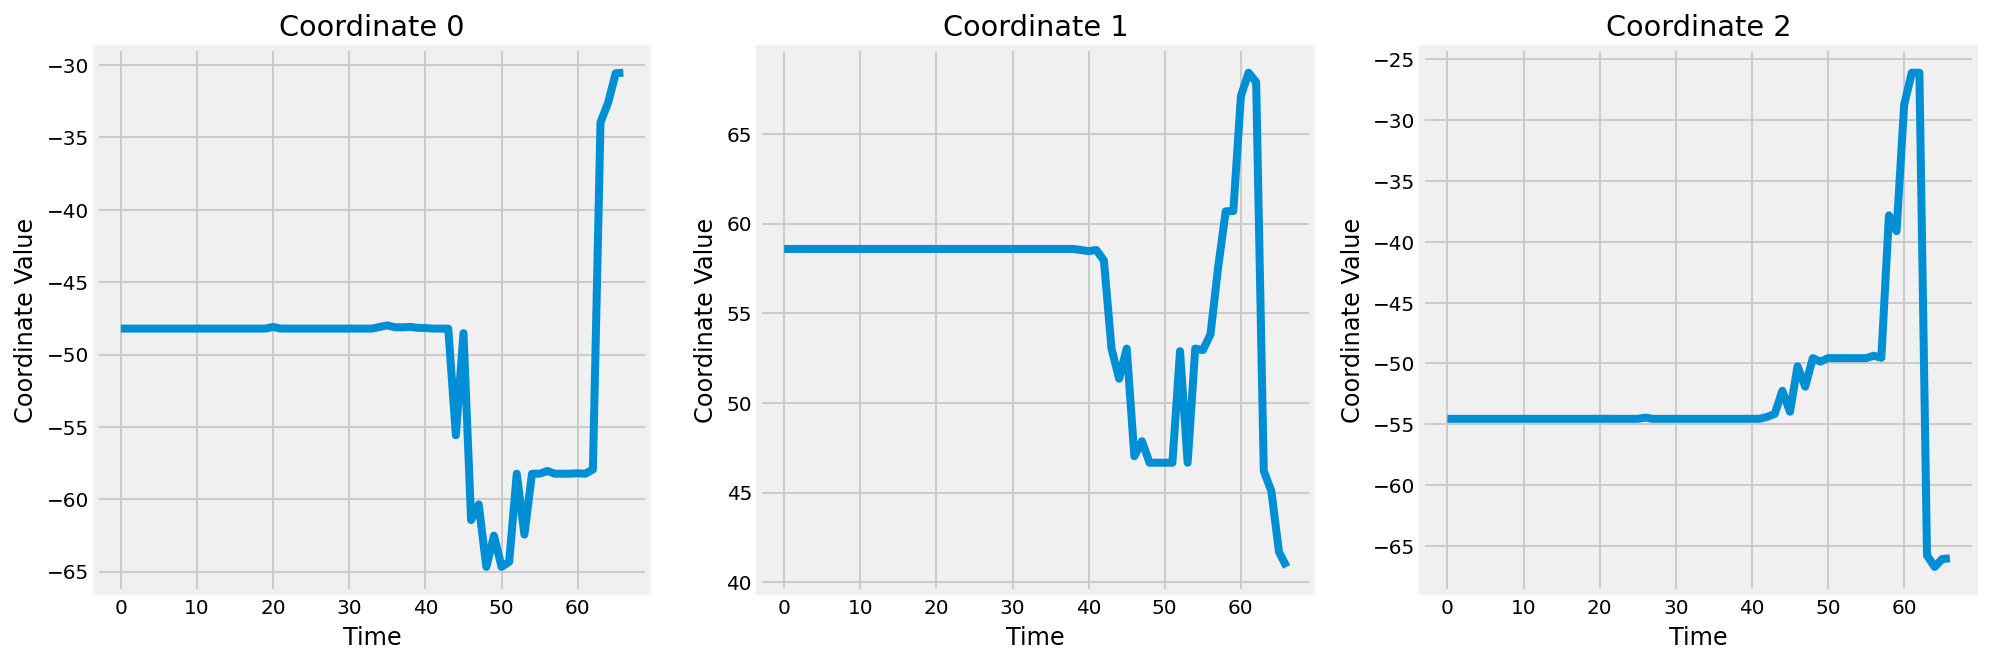

In [34]:
# by week
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(avg_coords_by_week['coord0'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Coordinate Value')
ax1.set_title('Coordinate 0')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(avg_coords_by_week['coord1'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Coordinate Value')
ax2.set_title('Coordinate 1')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(avg_coords_by_week['coord2'])
ax3.set_xlabel('Time')
ax3.set_ylabel('Coordinate Value')
ax3.set_title('Coordinate 2')
plt.show()

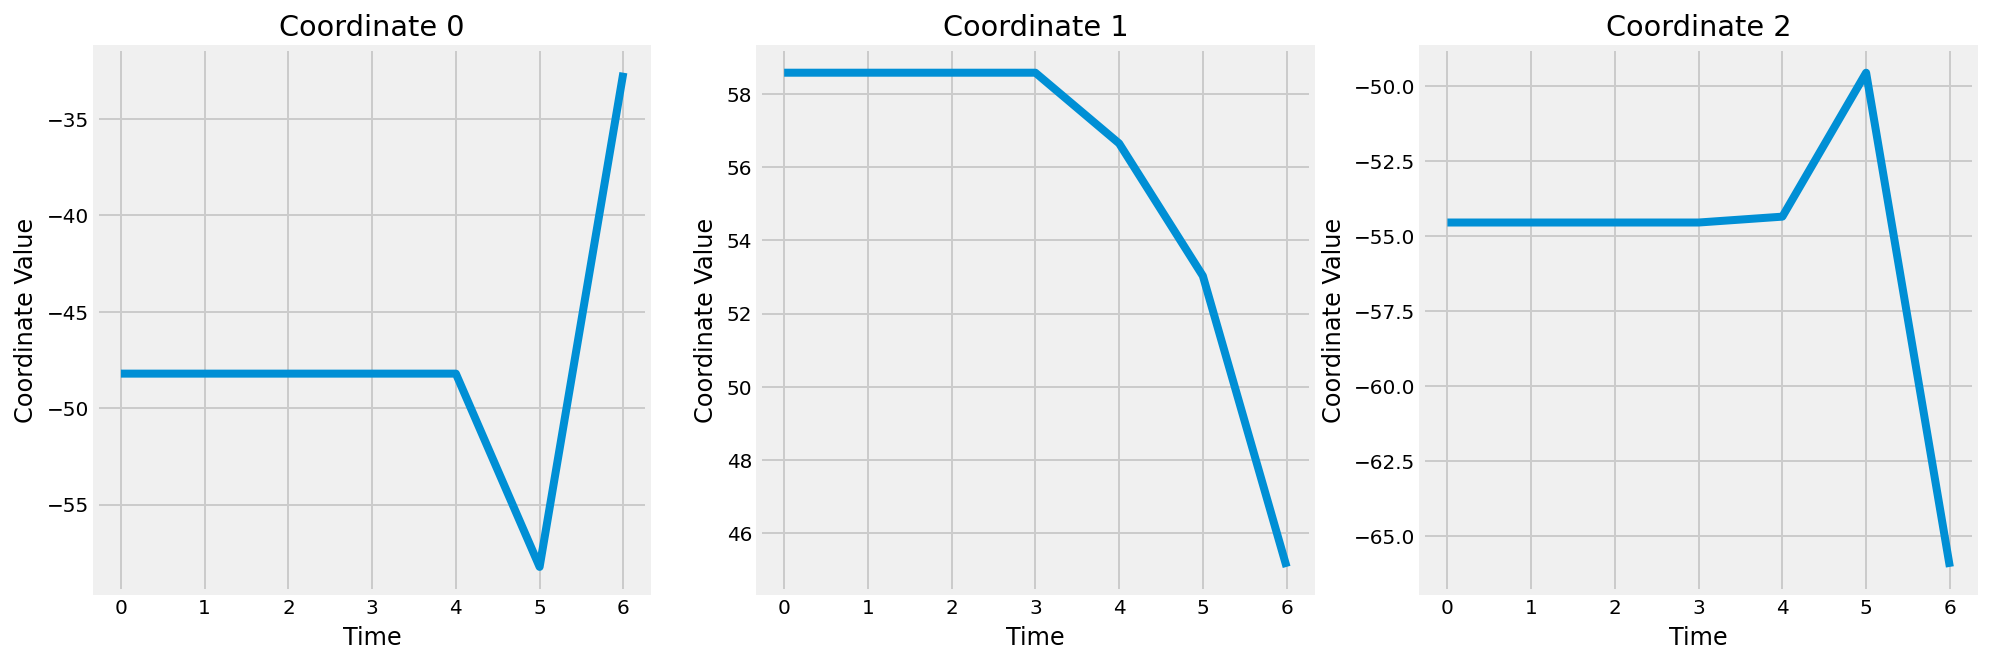

In [35]:
# by quarter
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(avg_coords_by_quarter['coord0'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Coordinate Value')
ax1.set_title('Coordinate 0')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(avg_coords_by_quarter['coord1'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Coordinate Value')
ax2.set_title('Coordinate 1')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(avg_coords_by_quarter['coord2'])
ax3.set_xlabel('Time')
ax3.set_ylabel('Coordinate Value')
ax3.set_title('Coordinate 2')
plt.show()

# GP for Timeseries

In [36]:
#GP by quarter
import theano.tensor as tt
x_vals = np.array(range(len(avg_coords_by_quarter))).reshape(-1, 1).astype('float32')

def build_coords_model(coordinate):
    y_vals = avg_coords_by_quarter[coordinate].values.astype('float32')
    
    print(x_vals.shape, y_vals.shape)

    with pm.Model() as model:
        # l = pm.HalfCauchy('l', beta=20)
        l = pm.Uniform('l', 0, 30)

        # Covariance function
        log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
        s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
        # s2_f = pm.HalfCauchy('s2_f', beta=2)
        # f_cov = s2_f * pm.gp.cov.Matern52(input_dim=1, lengthscales=l)
        f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=1, ls=l)

        # Sigma
        log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
        s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))
        # s2_n = pm.HalfCauchy('s2_n', beta=2)

        gp = pm.gp.Marginal(cov_func=f_cov)
        y_obs = gp.marginal_likelihood("y_obs", X=x_vals, y=y_vals, noise=s2_n)

        # y_obs = pm.gp.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, 
        #                  observed={'X':x_vals, 'Y':y_vals})
        trace = pm.sample(2000)
        pp_x = np.arange(len(avg_coords_by_quarter)+2)[:, None]

    with model:
        y_pred = gp.conditional("y_pred", Xnew = pp_x)
        gp_samples = pm.sample_posterior_predictive(trace = trace, var_names=["y_pred"], samples=1000)

    return gp_samples

In [37]:
#GP by week
import theano.tensor as tt
x_vals = np.array(range(len(avg_coords_by_week))).reshape(-1, 1).astype('float32')
weeks_pred = 21 # how many weeks does testing data pass through

def build_coords_model(coordinate):
    
    y_vals = avg_coords_by_week[coordinate].values.astype('float32')
    
    print(x_vals.shape, y_vals.shape)

    with pm.Model() as model:
        l = pm.Uniform('l', 0, 30)

        # Covariance function
        log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
        s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
        f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=1, ls=l)

        # Sigma
        log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
        s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))

        gp = pm.gp.Marginal(cov_func=f_cov)
        y_obs = gp.marginal_likelihood("y_obs", X=x_vals, y=y_vals, noise=s2_n)

        trace = pm.sample(2000)
        pp_x = np.arange(len(avg_coords_by_week)+ weeks_pred)[:, None]

    with model:
        y_pred = gp.conditional("y_pred", Xnew = pp_x)
        gp_samples = pm.sample_posterior_predictive(trace = trace, 
                                                    var_names=["y_pred"], 
                                                    samples=1000)

    return gp_samples

Now with the function defined, let's train three separate GP models to predict the evolutionary coordinates over time.

In [38]:
coord0_preds = build_coords_model('coord0')

(67, 1) (67,)


/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ERROR:pymc3:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [39]:
coord1_preds = build_coords_model('coord1')

(67, 1) (67,)


/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [41]:
coord2_preds = build_coords_model('coord2')

(67, 1) (67,)


ERROR:pymc3:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [42]:
coord0_preds, coord1_preds, coord2_preds = coord0_preds['y_pred'], coord1_preds['y_pred'], coord2_preds['y_pred'] 

In [43]:
coord0_preds.shape, coord1_preds.shape, coord2_preds.shape,

((1000, 88), (1000, 88), (1000, 88))

In [44]:
#save the GP coordinates
np.save('data/coord0_preds', coord0_preds)
np.save('data/coord1_preds', coord1_preds)
np.save('data/coord2_preds', coord2_preds)

In [45]:
# load the GP coordinates
coord0_preds = np.load('data/coord0_preds.npy')
coord1_preds = np.load('data/coord1_preds.npy')
coord2_preds = np.load('data/coord2_preds.npy')

Now, we can plot the coordinates with the ground truth data.

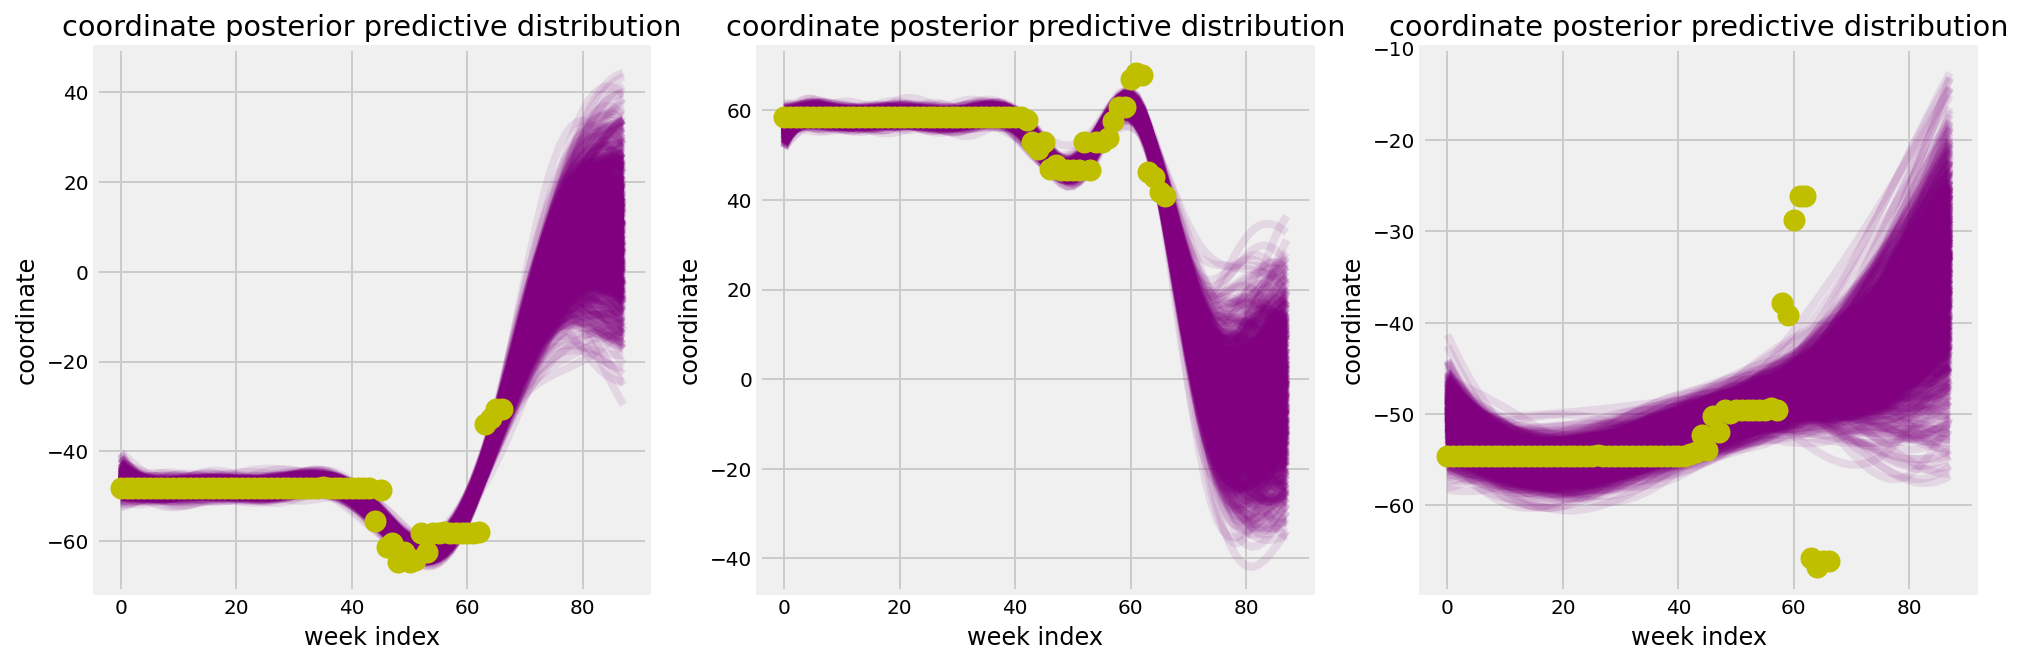

In [46]:
from random import sample
weeks_pred = 21 # how many weeks does testing data pass through
def plot_coords_with_groundtruth(coord_preds, data, ax):
    pp_x = np.arange(len(avg_coords_by_week)+weeks_pred)[:, None]
    for x in coord_preds:
        ax.plot(pp_x, x, color='purple', alpha=0.1)
    ax.plot(x_vals, data, 'oy', ms=10);
    ax.set_xlabel("week index");
    ax.set_ylabel("coordinate");
    ax.set_title("coordinate posterior predictive distribution");
    
    return ax

fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)
plot_coords_with_groundtruth(coord0_preds, avg_coords_by_week['coord0'], ax0)
plot_coords_with_groundtruth(coord1_preds, avg_coords_by_week['coord1'], ax1)
plot_coords_with_groundtruth(coord2_preds, avg_coords_by_week['coord2'], ax2)


I'd like to try making a Bokeh plot of this.

In [47]:
test_coords_embed = deepcopy(test_metadata)
test_coords_embed['coord0'] = test_embeddings_mean[:, 0]
test_coords_embed['coord1'] = test_embeddings_mean[:, 1]
test_coords_embed['coord2'] = test_embeddings_mean[:, 2]
test_coords_embed = test_coords_embed.set_index('Collection_Date').resample('W').mean().reset_index()
test_coords_embed.to_csv('data/test_metadata_with_embeddings.csv')
test_coords_embed

,Collection_Date,Length,coord0,coord1,coord2
0,2021-08-01,1273.0,-35.872562,45.019794,-59.170769
1,2021-08-08,1273.0,-31.565331,42.088043,-65.091927
2,2021-08-15,1273.0,-30.961658,41.477390,-66.146858
3,2021-08-22,1273.0,-31.398880,42.394672,-64.725868
4,2021-08-29,1273.0,-31.619934,41.530281,-66.188614
5,2021-09-05,1273.0,-31.660172,41.379398,-65.922943
6,2021-09-12,1273.0,-30.697626,41.062504,-66.023659
7,2021-09-19,1273.0,-31.778275,40.740582,-66.319962
8,2021-09-26,1273.0,-31.400372,41.778011,-66.190872
9,2021-10-03,1273.0,-32.266907,41.384106,-66.090935


In [48]:
# test_coords_embed[['coord0', 'coord1', 'coord2']].values
decoder.predict(test_coords_embed[['coord0', 'coord1', 'coord2']].values)

1/1 [==============================] - 0s 47ms/step


array([[8.8951077e-07, 1.4705054e-06, 1.0202209e-06, ..., 1.4038620e-06,
        8.7793779e-07, 8.6302197e-07],
       [9.9315980e-07, 1.9477345e-06, 1.2289300e-06, ..., 1.7576122e-06,
        1.0101948e-06, 9.7240593e-07],
       [1.0070993e-06, 2.0315172e-06, 1.2618196e-06, ..., 1.8121150e-06,
        1.0273200e-06, 9.8445219e-07],
       ...,
       [6.9031694e-07, 1.3560801e-06, 8.5301463e-07, ..., 1.2444164e-06,
        7.0940524e-07, 6.8794640e-07],
       [2.2856841e-06, 2.9617204e-06, 2.3676723e-06, ..., 2.8918935e-06,
        2.0868711e-06, 2.0605808e-06],
       [2.3748159e-06, 2.9368064e-06, 2.4102917e-06, ..., 2.8814461e-06,
        2.1325575e-06, 2.1077908e-06]], dtype=float32)

Make distribution plot that shows where the forecasts show up on the 95% credible interval.

In [49]:
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.layouts import row

def ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    return x, y

def percentile_xy(x, y, perc):
    return np.percentile(x, perc), np.percentile(y, perc)


def plot_forecast_hpd(coord_preds, coords_test, c, week):
  
    x, y = ecdf(coord_preds[:, -3+week])
    y_perc = (y * 100).astype('int')
    df = pd.DataFrame(dict(x=x, y=y, y_perc=y_perc))
    
    df['color'] = df['y_perc'].apply(lambda x: 'red' if x > 2.5 and x < 97.5 else 'blue')
    src = ColumnDataSource(df)

    
    # Instantiate Figure
    p = figure(plot_width=300, plot_height=300, 
               x_axis_label="coordinate value", y_axis_label="cumulative distribution",
               title="")

    # Make scatter plot.
    p.scatter('x', 'y', 
              color='color',
              source=src)
    p.ray(x=[coords_test['coord{0}'.format(c)][week-1]], y=[0], angle=np.pi / 2, length=0, line_width=2, color='blue')
#     p.scatter(*percentile_xy(x, y, 2.5), color='red')
#     p.scatter(*percentile_xy(x, y, 97.5), color='red')

    # Add Hover tool
    hovertool = HoverTool()
    hovertool.tooltips = [
        ("Value", "@x"),
        ("Percentile", "@y_perc")
    ]
    p.add_tools(hovertool)

    return p

q = 2
p0 = plot_forecast_hpd(coord0_preds, test_coords_embed, 0, week=q)
p1 = plot_forecast_hpd(coord1_preds, test_coords_embed, 1, week=q)
p2 = plot_forecast_hpd(coord2_preds, test_coords_embed, 2, week=q)

show(row(p0, p1, p2))

Decode the hold-out coordinates and check where they are in the forecasted sequences.

In [50]:
# coord0_preds[sample(range(len(coord0_preds)), 100)].tolist()
len(test_coords_embed)

21

In [51]:
output_notebook()
def plot_fore(coord):
    pred_length = len(test_coords_embed)
    p = figure(plot_width=300, plot_height=280, x_axis_label='Calendar Week', y_axis_label='Coordinate Value')
    pp_x = np.arange(len(avg_coords_by_week) + pred_length)[:, None]

    coord_pred_dict = {'coord0': coord0_preds,
                      'coord1': coord1_preds,
                      'coord2': coord2_preds,}

    n_samples = 200
    xs = list(pp_x.reshape(-1).repeat(n_samples).reshape(-1, n_samples).T.tolist())
    ys = coord_pred_dict['coord{0}'.format(coord)][sample(range(len(coord_pred_dict['coord{0}'.format(coord)])), n_samples)].tolist()
    p.multi_line(xs=xs, 
                ys=ys, 
                color='#fff176', 
                alpha=1)

    p.circle(x_vals.reshape(-1), avg_coords_by_week['coord{0}'.format(coord)], color='#616161')
    p.circle(pp_x[-pred_length:].reshape(-1), test_coords_embed['coord{0}'.format(coord)], color='#ff5252', radius=1)
    return p

show(row(plot_fore(0), plot_fore(1), plot_fore(2)))

We can see that the GPs learned the time-varying function pretty accurately, with some outliers smoothed out. Additionally, the uncertainty surrounding the two quarter forward predictions (right-most side of each plot) fan out, but not too much either. We can sample from these coordinates and generate back new sequence predictions.

In [52]:
one_week_pred = np.array([coord0_preds[:, -2], coord1_preds[:, -2], coord2_preds[:, -2]]).T
two_week_pred = np.array([coord0_preds[:, -1], coord1_preds[:, -1], coord2_preds[:, -1]]).T

# Grab out the 95% HPD interval from the data, filter out the data that are outside of HPD
oneQ_low, oneQ_high = get_density_interval(95, one_week_pred)
oneQ_low, oneQ_high

(array([-13.42682161, -26.73346316, -51.12784737]),
 array([ 32.6623521 ,  20.91813904, -21.45954518]))

Sanity check to see what `one_quarter_pred` looks like.

In [53]:
one_week_pred

array([[ 15.75496011,  -5.89234787, -34.2262303 ],
       [ 21.56760709, -13.72030716, -13.83556739],
       [  1.13370395,  11.67095869, -32.13507266],
       ...,
       [  9.47285861,   0.90183341, -47.07851272],
       [ -1.34061673,   1.41977583, -32.00285659],
       [ 16.78912879,  25.31784712, -24.17568825]])

In [54]:
test_embeddings_mean

array([[-33.915768,  39.28641 , -66.14669 ],
       [-33.915768,  39.28641 , -66.14669 ],
       [-33.915768,  39.28641 , -66.14669 ],
       ...,
       [-44.597897,  45.837612, -49.229973],
       [-44.590324,  45.442577, -48.73728 ],
       [-45.042526,  45.97491 , -49.20076 ]], dtype=float32)

Compute the convex hull of the scatter points, and check to see whether the predicted two weeks are within the predicted convex hull.

In [55]:
oneQ_hull = ConvexHull(one_week_pred)
twoQ_hull = ConvexHull(two_week_pred)

In [56]:
oneQ_hull.vertices

array([  1,   7,  10,  21,  22,  64,  91, 173, 199, 223, 254, 255, 291,
       293, 358, 398, 400, 414, 422, 435, 444, 458, 507, 518, 533, 590,
       595, 613, 640, 651, 705, 708, 721, 765, 817, 821, 833, 918, 970,
       974, 989], dtype=int32)

Quick sanity check - vary "dim" from 0-2; and check against test_coords_embed above: are they within the "cube" that is formed by convex hull vertices? (Granted: there's better methods for checking whether the predicted "average" sequence is within the convex hull, but this is quick-and-dirty.

In [57]:
dim = 2
one_week_pred[oneQ_hull.vertices][:, dim].min(), one_week_pred[oneQ_hull.vertices][:, dim].max()
# two_quarter_pred[twoQ_hull.vertices][:, dim].min(), two_quarter_pred[twoQ_hull.vertices][:, dim].max()

(-57.09717327463966, -13.835567386305861)

In [58]:
from ipywidgets import IntSlider
# @interact(elev=range(-180, 180, 20), azim=range(0, 360, 20))
def plot_predicted_coords(elev, azim):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(test_coords_embed['coord0'], test_coords_embed['coord1'], 
               test_coords_embed['coord2'], s=200)
    # ax.scatter(one_quarter_pred[:, 0], one_quarter_pred[:, 1], one_quarter_pred[:, 2], alpha=0.1)
    # ax.scatter(two_quarter_pred[:, 0], two_quarter_pred[:, 1], two_quarter_pred[:, 2], alpha=0.1)
    ax.set_facecolor('white')
    ax.view_init(elev=elev, azim=azim)
    
    for simplex in oneQ_hull.simplices:
        ax.plot(one_week_pred[simplex, 0], 
                 one_week_pred[simplex, 1], 
                 one_week_pred[simplex, 2], 
                 'b-', lw=0.2)
    plt.show()
    
elev_slider = IntSlider(value=0, min=-180, max=180, step=20)
azim_slider = IntSlider(value=60, min=0, max=360, step=20)
interact(plot_predicted_coords, elev=elev_slider, azim=azim_slider)

interactive(children=(IntSlider(value=0, description='elev', max=180, min=-180, step=20), IntSlider(value=60, …

<function __main__.plot_predicted_coords(elev, azim)>

In [59]:
#two-week before end-point
from ipywidgets import IntSlider
# @interact(elev=range(-180, 180, 20), azim=range(0, 360, 20))
def plot_predicted_coords(elev, azim):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(test_coords_embed['coord0'], test_coords_embed['coord1'], 
               test_coords_embed['coord2'], s=200)
    # ax.scatter(one_quarter_pred[:, 0], one_quarter_pred[:, 1], one_quarter_pred[:, 2], alpha=0.1)
    # ax.scatter(two_quarter_pred[:, 0], two_quarter_pred[:, 1], two_quarter_pred[:, 2], alpha=0.1)
    ax.set_facecolor('white')
    ax.view_init(elev=elev, azim=azim)
    
    for simplex in twoQ_hull.simplices:
        ax.plot(two_week_pred[simplex, 0], 
                 two_week_pred[simplex, 1], 
                 two_week_pred[simplex, 2], 
                 'b-', lw=0.2)
    plt.show()
    
elev_slider = IntSlider(value=0, min=-180, max=180, step=20)
azim_slider = IntSlider(value=60, min=0, max=360, step=20)
interact(plot_predicted_coords, elev=elev_slider, azim=azim_slider)

interactive(children=(IntSlider(value=0, description='elev', max=180, min=-180, step=20), IntSlider(value=60, …

<function __main__.plot_predicted_coords(elev, azim)>

In [60]:
from ipywidgets import IntSlider
twenty_one_week_pred = np.array([coord0_preds[:, -21], coord1_preds[:, -21], coord2_preds[:, -21]]).T
twenty_one_W_hull = ConvexHull(twenty_one_week_pred)
# @interact(elev=range(-180, 180, 20), azim=range(0, 360, 20))
def plot_predicted_coords(elev, azim):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(test_coords_embed['coord0'], test_coords_embed['coord1'], 
               test_coords_embed['coord2'], s=200)
    # ax.scatter(one_quarter_pred[:, 0], one_quarter_pred[:, 1], one_quarter_pred[:, 2], alpha=0.1)
    # ax.scatter(two_quarter_pred[:, 0], two_quarter_pred[:, 1], two_quarter_pred[:, 2], alpha=0.1)
    ax.set_facecolor('white')
    ax.view_init(elev=elev, azim=azim)
    
    for simplex in twenty_one_W_hull.simplices:
        ax.plot(twenty_one_week_pred[simplex, 0], 
                twenty_one_week_pred[simplex, 1], 
                twenty_one_week_pred[simplex, 2], 
                 'b-', lw=0.2)
    plt.show()
    
elev_slider = IntSlider(value=0, min=-180, max=180, step=20)
azim_slider = IntSlider(value=60, min=0, max=360, step=20)
interact(plot_predicted_coords, elev=elev_slider, azim=azim_slider)

interactive(children=(IntSlider(value=0, description='elev', max=180, min=-180, step=20), IntSlider(value=60, …

<function __main__.plot_predicted_coords(elev, azim)>

In [61]:
from ipywidgets import IntSlider
twenty_week_pred = np.array([coord0_preds[:, -20], coord1_preds[:, -20], coord2_preds[:, -20]]).T
twenty_W_hull = ConvexHull(twenty_week_pred)
# @interact(elev=range(-180, 180, 20), azim=range(0, 360, 20))
def plot_predicted_coords(elev, azim):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(test_coords_embed['coord0'], test_coords_embed['coord1'], 
               test_coords_embed['coord2'], s=200)
    # ax.scatter(one_quarter_pred[:, 0], one_quarter_pred[:, 1], one_quarter_pred[:, 2], alpha=0.1)
    # ax.scatter(two_quarter_pred[:, 0], two_quarter_pred[:, 1], two_quarter_pred[:, 2], alpha=0.1)
    ax.set_facecolor('white')
    ax.view_init(elev=elev, azim=azim)
    
    for simplex in twenty_W_hull.simplices:
        ax.plot(twenty_week_pred[simplex, 0], 
                twenty_week_pred[simplex, 1], 
                twenty_week_pred[simplex, 2], 
                 'b-', lw=0.2)
    plt.show()
    
elev_slider = IntSlider(value=0, min=-180, max=180, step=20)
azim_slider = IntSlider(value=60, min=0, max=360, step=20)
interact(plot_predicted_coords, elev=elev_slider, azim=azim_slider)

interactive(children=(IntSlider(value=0, description='elev', max=180, min=-180, step=20), IntSlider(value=60, …

<function __main__.plot_predicted_coords(elev, azim)>

Now, let's try sampling out sequences from this coordinate space.

In [62]:
from custom import embedding2binary, binary2chararray
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

In [63]:
from collections import Counter

def embedding2seqs(decoder, preds, sequences):
    binary = embedding2binary(decoder, preds)
    chararray = binary2chararray(sequences, binary)
    strs = [''.join(i for i in k) for k in chararray]
    strcounts = Counter(strs)
    seqrecords = []
    for s, c in sorted(strcounts.items(), key=lambda x: x[1], reverse=True):
        s = Seq(s)
        sr = SeqRecord(s, id='weight_' + str(c))
        seqrecords.append(sr)
        
    return binary, chararray, strcounts, strs, seqrecords
    
oneQ_binary, oneQ_chararray, oneQ_strcounts, oneQ_strs, oneQ_seqrecords = embedding2seqs(decoder, one_week_pred, sequences)
twoQ_binary, twoQ_chararray, twoQ_strcounts, twoQ_strs, twoQ_seqrecords = embedding2seqs(decoder, two_week_pred, sequences)
twenty_one_W_binary, twenty_one_W_chararray, twenty_one_W_strcounts, twenty_one_W_strs, twenty_one_W_seqrecords = embedding2seqs(decoder, twenty_one_week_pred, sequences)
twenty_W_binary, twenty_W_chararray, twenty_W_strcounts, twenty_W_strs, twenty_W_seqrecords = embedding2seqs(decoder, twenty_week_pred, sequences)

32/32 [==============================] - 0s 3ms/step


In [64]:
twoQ_strcounts.values()

dict_values([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 10, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [65]:
print(len(oneQ_strcounts.keys()))
print(len(twoQ_strcounts.keys()))
print(len(twenty_W_strcounts.keys()))
print(len(twenty_one_W_strcounts.keys()))

926
913
73
31


In [ ]:
# oneQ_binary = embedding2binary(decoder, one_quarter_pred)
# oneQ_chararray = binary2chararray(sequences, oneQ_binary)

In [ ]:
# twoQ_binary = embedding2binary(decoder, two_quarter_pred)
# twoQ_chararray = binary2chararray(sequences, twoQ_binary)

Now, we can save the data to disk.

In [66]:

# # Data structure here: 
# oneQ_strs = Counter([''.join(i for i in k) for k in oneQ_chararray])

# oneQ_seqrecords = []
# for s, c in sorted(oneQ_strs.items(), key=lambda x: x[1], reverse=True):
#     s = Seq(s)
#     sr = SeqRecord(s, id='weight_' + str(c))
#     oneQ_seqrecords.append(sr)
    
# # Write to disk
SeqIO.write(oneQ_seqrecords, 'data/oneQ_predictions.fasta', 'fasta')
SeqIO.write(twoQ_seqrecords, 'data/twoQ_predictions.fasta', 'fasta')

913

In [67]:
test_binarray = embedding2binary(decoder, test_coords_embed.loc[:, ['coord0', 'coord1', 'coord2']].values)
test_chararray = binary2chararray(sequences, test_binarray)
test_strs = [''.join(i for i in k) for k in test_chararray]
test_seqrecords = [SeqRecord(seq=Seq(i)) for n, i in enumerate(test_strs)]

1/1 [==============================] - 0s 18ms/step


In [68]:
twoQ_strcounts[test_strs[1]]
oneQ_strcounts[test_strs[0]]

0

In [69]:
sorted(oneQ_strcounts.values(), reverse=True)[0:3]

[6, 5, 5]

In [70]:
sorted(twoQ_strcounts.values(), reverse=True)[0:3]

[10, 9, 5]

# Sampled Point Cloud

I would like to visualize the sampled point cloud. Each unique sequence will be given a unique colour. Let's see how much volume each sequence takes.

In [71]:
from palettable.tableau import Tableau_20
from matplotlib.colors import ListedColormap
from itertools import cycle
from datetime import datetime

def make_predcoords_df(strcounts, strs, chararray, pred):
    """
    Just a utility function for the notebook. DO NOT PUT INTO PRODUCTION!
    """

    # cm = discrete_cmap(len(strcounts.keys()), base_cmap=Tableau_20)
    cmap_mpl = dict()
    for (seq, rgb) in zip(strcounts.keys(), cycle(Tableau_20.mpl_colors)):
        cmap_mpl[seq] = rgb

    cmap_hexcol = dict()
    for (seq, hexcol) in zip(strcounts.keys(), cycle(Tableau_20.hex_colors)):
        cmap_hexcol[seq] = hexcol
    
    mpl_colors = [cmap_mpl[s] for s in strs]
    hex_colors = [cmap_hexcol[s] for s in strs]    
    
    predcoords = pd.DataFrame()
    predcoords['coords0'] = pred[:, 0]
    predcoords['coords1'] = pred[:, 1]
    predcoords['coords2'] = pred[:, 2]
    predcoords['matplotlib_colors'] = mpl_colors
    predcoords['hexdecimal_colors'] = hex_colors
    
    return predcoords
    
oneQ_predcoords = make_predcoords_df(oneQ_strcounts, oneQ_strs, oneQ_chararray, one_week_pred)
twoQ_predcoords = make_predcoords_df(twoQ_strcounts, twoQ_strs, twoQ_chararray, two_week_pred)

oneQ_predcoords.to_csv('data/oneQ_prediction_coords_with_colors.csv')
twoQ_predcoords.to_csv('data/twoQ_prediction_coords_with_colors.csv')

dim1 = 'coords0'
dim2 = 'coords2'

def make_bokeh_plot_predcoord_bounding_boxes(predcoords, dim1, dim2):
    """
    This is just a plot made for diagnostic purposes. DO NOT PUT INTO PRODUCTION!
    """
    
    assert dim1 != dim2
    p = figure(plot_width=400, plot_height=300)
    xs_all = []
    ys_all = []
    colors = []
    starttime = datetime.now()
    for (mpl_color, hex_color), dat in oneQ_predcoords.groupby(['matplotlib_colors', 'hexdecimal_colors']):
        d = dat[[dim1, dim2]]
        
        if len(d) >=10:
            xs = []
            ys = []
            hull = ConvexHull(d[[dim1, dim2]])
            for v in hull.vertices:
                xs.append(d.iloc[v][dim1])
                ys.append(d.iloc[v][dim2])
            xs.append(xs[0])
            ys.append(ys[0])
            xs_all.append(xs)
            ys_all.append(ys)
            colors.append(hex_color)
    p.multi_line(xs_all, ys_all, color=colors)
    endtime = datetime.now()
    elapsed = endtime - starttime
    print(f'elapsed time: {elapsed} s')

    show(p)
    
make_bokeh_plot_predcoord_bounding_boxes(twoQ_predcoords, 'coords0', 'coords2')

elapsed time: 0:00:00.051416 s


# Further Check

I wanted to check whether actual sequences looked anything like the "average" sequence. This is the sanity check below.

In [72]:
most_probable_seq = str(oneQ_seqrecords[0].seq)

Text(0, 0.5, 'Cumulative distribution')

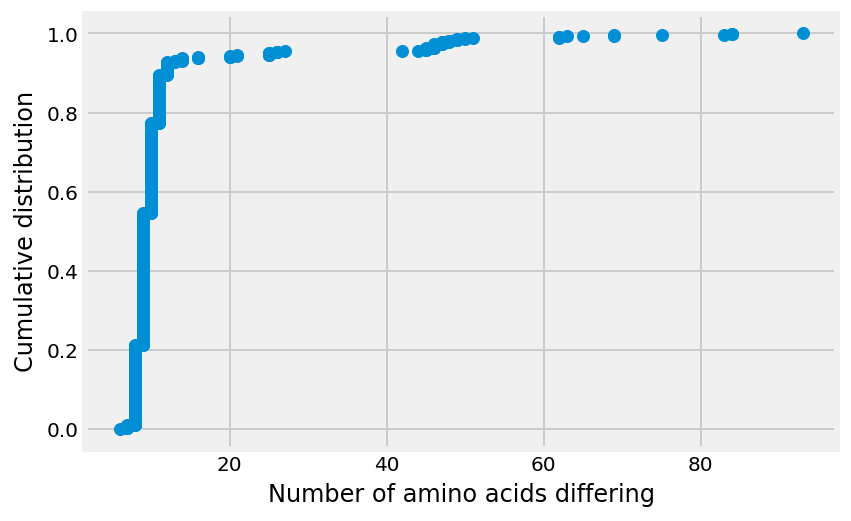

In [73]:
from Levenshtein import distance
levDs_from_preds = [distance(str(record.seq), most_probable_seq) for record in test_sequences]

def ecdf_scatter(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x, y)
    
    return ax
    
    
ax = ecdf_scatter(levDs_from_preds)
ax.set_xlabel('Number of amino acids differing')
ax.set_ylabel('Cumulative distribution')

Text(0, 0.5, 'Cumulative distribution')

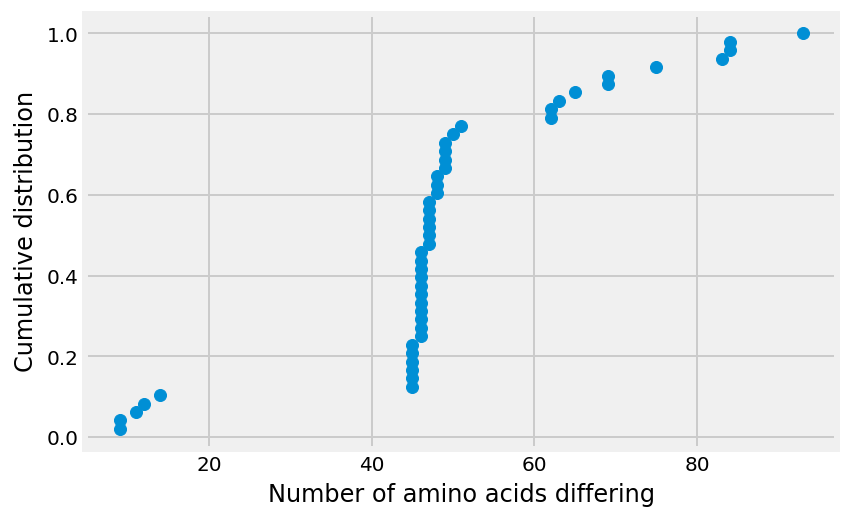

In [74]:
Dec_test_metadata = metadata[metadata['Collection_Date'] >= datetime(2021, 12, 1)]
Dec_test_idx = [i for i, s in enumerate(sequences) if s.id in Dec_test_metadata['Accession'].values]
Dec_test_seq = [sequences[i] for i in Dec_test_idx]
levDs_from_preds_Dec = [distance(str(record.seq), most_probable_seq) for record in Dec_test_seq]
ax = ecdf_scatter(levDs_from_preds_Dec)
ax.set_xlabel('Number of amino acids differing')
ax.set_ylabel('Cumulative distribution')